In [110]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import integrate
import xarray as xr

In [66]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007    

In [172]:
lats = np.arange(-90, 91, 1)

### Load in reanalysis

In [191]:
era5_ds = xr.open_dataset('../aaron_aht_stuff/era5_aht.nc').sel(time=slice('1980-01-01','2014-12-31'))
era_interim_ds = xr.open_dataset('../aaron_aht_stuff/era_interim.nc').sel(time=slice('1980-01-01','2014-12-31'))
merra_ds = xr.open_dataset('../merra_data/merra_aht.nc').sel(time=slice('1980-01-01','2014-12-31'))
jra_ds = xr.open_dataset('../JRA_aht/jra_aht.nc').sel(time=slice('1980-01-01','2014-12-31'))

#Times mean the same thing, this makes them actually identical
merra_ds['time'] = era5_ds.time
jra_ds['time'] = era5_ds.time

era5_trends = era5_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
merra_trends = merra_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
era_interim_trends = era_interim_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
jra_trends = jra_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

In [67]:
test = xr.open_dataset('/skdat0/lchahn/amip6/hus_Amon_CNRM-CM6-1_amip_r1i1p1f2_gr_197901-201412.nc')

In [68]:
test

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, plev: 19, time: 432, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * plev         (plev) float32 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * time         (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] ...
    hus          (time, plev, lat, lon) float32 ...
Attributes: (12/51)
    Conventions:           CF-1.7 CMIP-6.2
    creation_date:         2018-07-11T12:27:39Z
    description:           DECK: AMIP
    title:                 CNRM-CM6-1 model output prepared for CMIP6 / CMIP ...
    activity_id:           CMIP
    contact:               contact.cmip@meteo.fr
    ...                    ...
    parent_mip_era:        no parent
    parent_source_id:      no parent
    parent_time_units:     no parent
    parent_variant_label:  no parent
    history:               none
    tracking_id:           hdl:21.14100/d048f0bb-e898-4601-9442-399b6b605517

In [223]:
def grab_aht_lily(datas):
    
    times = pd.date_range('1979-01-01', '2014-12-31', freq='1M')
    aht = datas.aht
    lats = datas.lat.values
    
    final_lat = np.arange(-90, 91, 1)
    
    time_shape = datas.dims['ncl0']
    lat_shape = datas.dims['ncl1']
    lon_shape = datas.dims['ncl2']
    
    aht_zonal = np.mean(aht.values.reshape((time_shape, lat_shape, lon_shape)), axis=2)

    aht_mean = np.nansum(aht_zonal*np.cos(lats*np.pi/180)[None,:], axis=1)/np.nansum(np.cos(lats*np.pi/180))

    geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

    aht_no_mean = aht_zonal - aht_mean[:,None]


    aht_final = -integrate.cumtrapz(aht_no_mean, x=np.sin(lats*np.pi/180), axis=1, initial=0) * 2*np.pi*a**2
    
    aht_da = xr.DataArray(aht_final, dims=('time', 'latitude'), coords={'time':times, 'latitude':lats})
    
    aht_da = aht_da.interp(latitude=final_lat)
    
    return aht_da

In [224]:
all_datas = []

files = glob.glob('/skdat0/lchahn/amip6/amip6_seasonal_wm2ahtoht*.nc')

for file in files:
    
    try:
        datas = xr.open_dataset(file)
        aht = grab_aht_lily(datas)
        all_datas.append(aht)
    except:
        print(file)

In [233]:
for file in files:
    splits = file.split('_')
    print(splits[-1][:-3])

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CMCC-CM2-HR4
CMCC-CM2-SR5
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
CanESM5
E3SM-1-0
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg
FGOALS-f3-L
FGOALS-g3
GFDL-CM4
GISS-E2-1-G
GISS-E2-2-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
MIROC-ES2L
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorCPM1
NorESM2-LM
SAM0-UNICON
TaiESM1
UKESM1-0-LL


In [225]:
all_aht = xr.concat(all_datas, pd.Index(np.arange(len(all_datas)), name='model')).sel(time=slice('1980-01-01','2014-12-31'))

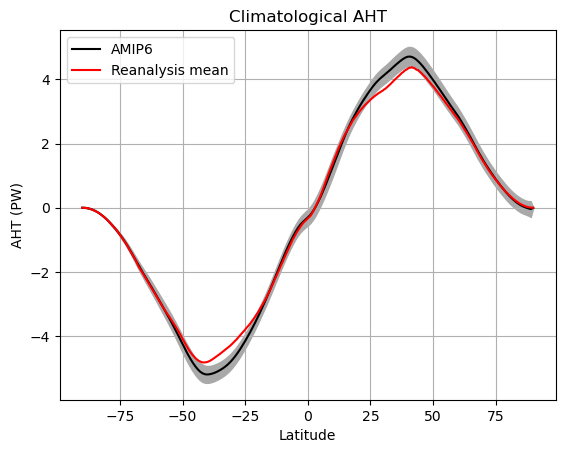

In [226]:
all_aht_mean = all_aht.mean(['time','model'])
aht_model_std = all_aht.mean(['time']).std('model')

plt.fill_between(lats, (all_aht_mean - aht_model_std)/1e15, (all_aht_mean + aht_model_std)/1e15, color='darkgrey')

plt.plot(lats, all_aht_mean/1e15, color='k', label='AMIP6')

#Make reanalysis mean
era_interim_tot_regrid = era_interim_ds.total_aht.interp(latitude=era5_ds.latitude)
merra_tot_regrid = merra_ds.total_aht.interp(latitude=era5_ds.latitude)
jra_tot_regrid = jra_ds.total_aht.interp(latitude=era5_ds.latitude)

tot_mean = (era_interim_tot_regrid + era5_ds.total_aht + merra_tot_regrid + jra_tot_regrid)/4

plt.plot(era5_ds.latitude, tot_mean.mean('time')/1e15, color='r', label='Reanalysis mean')

plt.grid()

plt.legend(loc=0)
plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

plt.title('Climatological AHT')

#plt.savefig('../figures/aht_trends/amip6_reanalysis_tot_aht_mean')
plt.show()

In [227]:
all_aht_trend = all_aht.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

#Make reanalysis mean
era_interim_tot_trend_regrid = era_interim_trends.total_aht_polyfit_coefficients.sel(degree=1).interp(latitude=era5_ds.latitude)
merra_tot_trend_regrid = merra_trends.total_aht_polyfit_coefficients.sel(degree=1).interp(latitude=era5_ds.latitude)
jra_tot_trend_regrid = jra_trends.total_aht_polyfit_coefficients.sel(degree=1).interp(latitude=era5_ds.latitude)

tot_trend_mean = (era_interim_tot_trend_regrid + era5_trends.total_aht_polyfit_coefficients.sel(degree=1) + merra_tot_trend_regrid + jra_tot_trend_regrid)/4



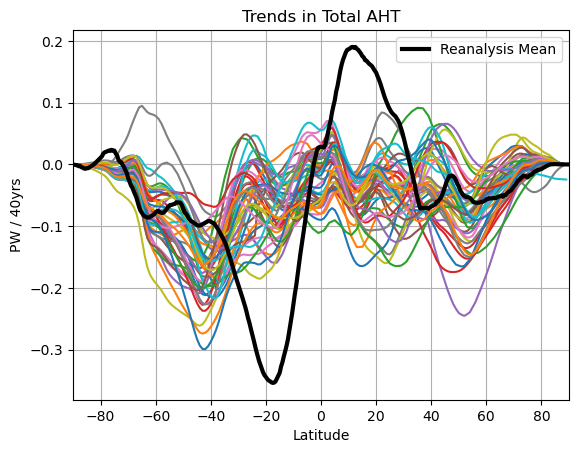

In [228]:
(40 * all_aht_trend.polyfit_coefficients.sel(degree=1) / 1e15).plot.line(x='latitude', add_legend=False)

(40 * tot_trend_mean / 1e15).plot(color='k', lw=3, label='Reanalysis Mean')

plt.xlim([-90, 90])

plt.legend(loc=0)
plt.xlabel('Latitude')
plt.ylabel('PW / 40yrs')
plt.title('Trends in Total AHT')

plt.grid()
#plt.savefig('../figures/aht_trends/amip_all_reanalysis_total_aht_trend')
plt.show()

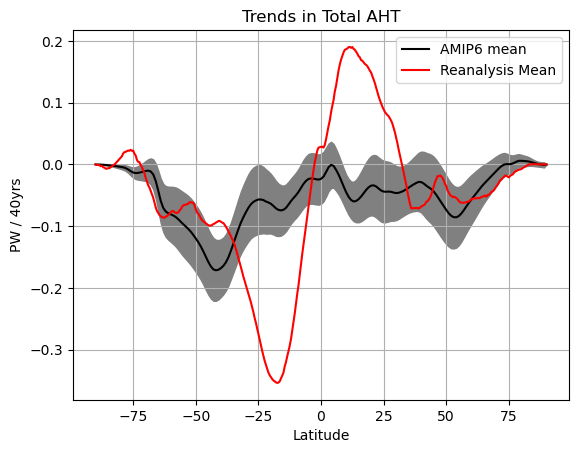

In [229]:

all_aht_mean_trend = 40 * all_aht_trend.polyfit_coefficients.sel(degree=1).mean('model') / 1e15
aht_model_std_trend = 40 * all_aht_trend.polyfit_coefficients.sel(degree=1).std('model') / 1e15

plt.fill_between(lats, all_aht_mean_trend - aht_model_std_trend, all_aht_mean_trend + aht_model_std_trend, color='grey')

plt.plot(lats, all_aht_mean_trend, color='k', label='AMIP6 mean')

(40 * tot_trend_mean / 1e15).plot(color='r', label='Reanalysis Mean')

plt.grid()

plt.legend(loc=0)
plt.xlabel('Latitude')
plt.ylabel('PW / 40yrs')
plt.title('Trends in Total AHT')

#plt.savefig('../figures/aht_trends/amip_mean_reanalysis_total_aht_trend')

plt.show()